<a href="https://colab.research.google.com/github/envgp/taking_the_pulse_of_the_planet/blob/main/notebooks/pulse_assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7: Taking the Pulse of Cities
Annie Kroo (akroo@stanford.edu), Stanford Electrical Engineering, Margo Crawford, Upstream Tech, Tehya Stockman, CU Boulder Air Quality Environmental Engineering, Lauren Gulland, Upstream Tech

This assignment is due on `2023-3-07`. Please put your answers within this notebook and share the completed notebook with the graders, bsalvado@stanford.edu and mmorphew@stanford.edu, using the Share banner located at the top right corner of this notebook. When sharing your notebook, please change the name of the notebook and add your name and sunetid (e.g., pulse_course_assignment_2_firstname_lastname_sunetid.ipynb)

## INTRODUCTION TO THE ASSIGNMENT


In [ ]:
#Download important packages to runtime
!pip install xarray numpy pandas geopandas cartopy==0.19.0.post1 rioxarray ipywidgets
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install sparse
!pip install verde
!pip install pykrige
!pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1.tar.gz (275 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801328cba85cf6ace157da31a4007bca85e4/shapely-2.0.1.tar.gz#sha256=66a6b1a3e72ece97fc85536a281476f9b7794de2e646ca8a4517e2e3c1446893 (from https://pypi.org/simple/shapely/) (requires-python:>=3.7): Requested unknown from https://files.pythonhosted.org/packages/10/a7/de139da3ce303101c357a9ba801

In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import NaN
from decimal import Decimal
import pandas as pd
import math
import datetime
from datetime import time
import calendar
import seaborn as sns
from IPython.core.display import display, HTML
import itertools
import scipy
display(HTML("<style>.container { width:100% !important; }</style>"))
import geopandas as gpd
import numpy as np
import seaborn
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
from numpy import matlib
import shapely
from shapely.geometry import mapping
matplotlib.rcParams['font.size'] = 14
from ipywidgets import widgets, interact
import rioxarray
import sparse
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

In [ ]:
!git clone https://premonition.stanford.edu/sgkang09/taking_the_pulse_city_data.git

Cloning into 'taking_the_pulse_city_data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 1.16 MiB | 1.58 MiB/s, done.


In [ ]:

# Functions to pull in BEACO2N data from the website
# For more information on this dataset visit: http://beacon.berkeley.edu
# Note: each node is identified by a node_id in the file. Richmond Field Station is 41, Laney College is 45, etc.
# The column names in the resulting data frame are the node IDs

# Pulling the CO2 data from all the node IDs listed given the start and end date
def co2(start,end,nodes):
    full = pd.DataFrame()
    for i in tqdm (range (len(nodes)),
               desc="Loading…",
               ascii=False, ncols=75):
      node = str(nodes[i])
      try:
        filename="http://beacon.berkeley.edu/node/"+node+"/measurements/csv?name=Multiselect%20Download&interval=60&start="+start+"&end="+end
        data  = pd.read_csv(filename,index_col=[0], parse_dates=[0])
        data = data.drop(data.filter(regex='co_|PM').columns, axis=1)
        data = data.drop(['epoch','datetime', 'node_id', 'julian_day'],axis = 1)
        data = data.replace(-999,np.NaN)
        data.dropna(inplace=True)
        data = data.drop(data.filter(regex='QC').columns, axis=1)
        data = data.rename(columns={data.columns[0]: node})
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True) 
      except:
        continue
    return full


# PM2.5 data
def pm2_5(start,end,nodes):
    full = pd.DataFrame()
    for i in tqdm (range (len(nodes)),
               desc="Loading…",
               ascii=False, ncols=75):
      node = str(nodes[i])
      try:
        filename="http://beacon.berkeley.edu/node/"+node+"/measurements/csv?name=Multiselect%20Download&interval=60&start="+start+"&end="+end
        data  = pd.read_csv(filename,index_col=[0], parse_dates=[0])
        data = data.drop(data.filter(regex='co').columns, axis=1)
        data = data.drop(['epoch','datetime', 'node_id', 'julian_day'],axis = 1)
        data = data.replace(-999,np.NaN)
        data.dropna(inplace=True)
        data = data.drop(data.filter(regex='QC').columns, axis=1)
        data = data.rename(columns={data.columns[0]: node})
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True) 
      except:
        continue
    return full


# CO data
def co(start,end,nodes):
    full = pd.DataFrame()
    for i in tqdm (range (len(nodes)),
               desc="Loading…",
               ascii=False, ncols=75):
      node = str(nodes[i])
      try:
        filename="http://beacon.berkeley.edu/node/"+node+"/measurements/csv?name=Multiselect%20Download&interval=60&start="+start+"&end="+end
        data  = pd.read_csv(filename,index_col=[0], parse_dates=[0])
        data = data.drop(data.filter(regex='co2_|PM').columns, axis=1)
        data = data.drop(['epoch','datetime', 'node_id', 'julian_day'],axis = 1)
        data = data.replace(-999,np.NaN)
        data.dropna(inplace=True)
        data = data.drop(data.filter(regex='QC').columns, axis=1)
        data = data.rename(columns={data.columns[0]: node})
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True) 
      except:
        continue
    return full


In [ ]:
#Pulling just the oakland sites
sites = [3,33,38,40,45,49,44,45]
lat = [37.824,37.804,37.779,37.809,37.794,37.775,37.809,37.819]
lon = [-122.233,-122.237,-122.222,-122.205,-122.263,-122.167,-122.263,-122.181]

# Pulling PM2.5 data in ug/m^3
pm2_5_vals = pm2_5('2022-02-01%2000:00:00','2022-03-1%2000:00:00',sites)

# Pulling CO2 data in ppm
CO2_vals = co2('2022-02-01%2000:00:00','2022-03-1%2000:00:00',sites)

Loading…: 100%|██████████████████████████████| 8/8 [00:21<00:00,  2.75s/it]


Text(0, 0.5, 'CO2 Concentration (ppm)')

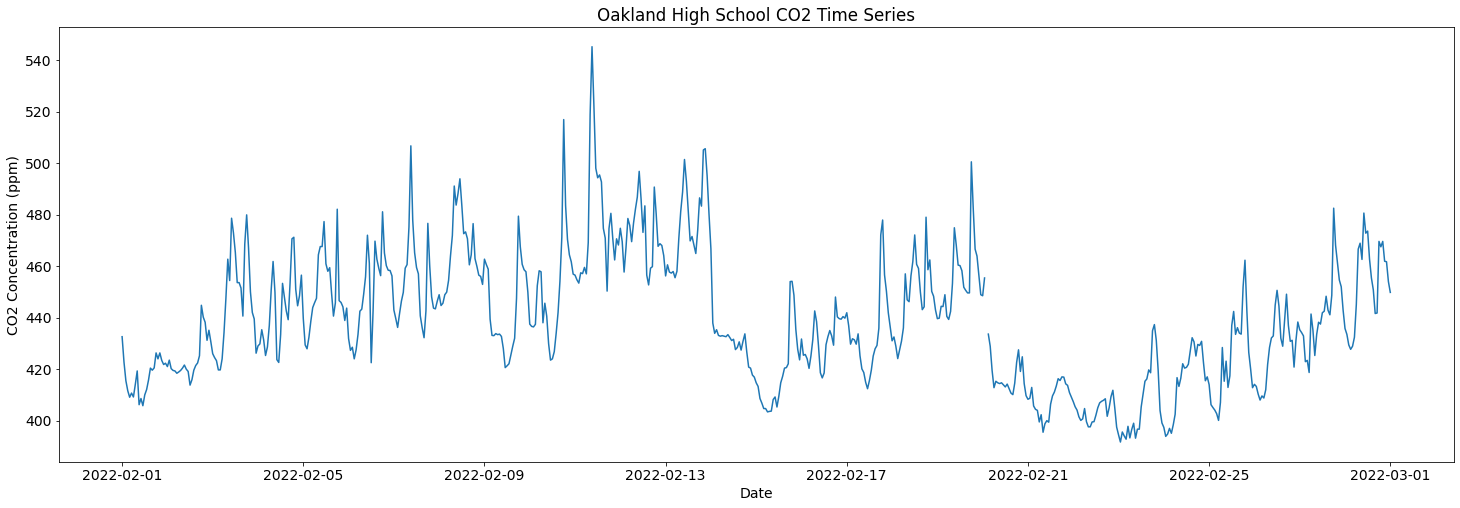

In [ ]:

# Plotting the time series of CO2 at Beverly Hills Elementary School (Node ID 81)
plt.figure(figsize = (25, 8))
plt.plot(CO2_vals['40'])
plt.title("Oakland High School CO2 Time Series")
plt.xlabel("Date")
plt.ylabel("CO2 Concentration (ppm)")


#Problem 1:

**Part A)** Using a similar process to what was above load the whole year for 2020. Plot the timeseries of the year. What do you observe in this time series?

**Part B)** In recent years, California's fire season has been very pronounced. In 2021, there were a series of fires in August-October. Look through the data for site 33 (Oakland High). Can you see the fire season in the pm2.5 data? How about the co2 data?

#Working with Low Cost Sensor Data
There are many ways to go about collecting data. In the process of designing an experiment, you have to make trade-offs between the quanity and quality of sensors given practical constraints on funding. You have heard in class today about Ron Cohen's sensors and have now played a little with the data from his instrument that is approximately \$8k-$10k per node.

In addition to these scientific grade sensors put out into the field by researchers, communities have begun monitoring air quality for health and safety. These low cost (~\$50) sensors help individuals make informed decisions about their health. Armed with access to this information, individuals can change their behaviors to mitigate health risks associated with poor air quality such as turning on an air purifier, or chosing to not exercise if there are a lot of particulates suspended in the air.

As scientists, we can access these community driven projects such as Purple Air and use these data to learn more about air quality in cities to inform policy and generate scientific insights.

https://explore.openaq.org/


###Read in the *data*

In [ ]:
oak = gpd.read_file('./taking_the_pulse_city_data/Priority_Neighborhoods.shx')
oak['coords'] = oak['geometry'].apply(lambda x: x.representative_point().coords[:])
oak['coords'] = [coords[0] for coords in oak['coords']]
df_oak = pd.read_csv('./taking_the_pulse_city_data/oak_7km_2_22.csv')
df_oak.rename(columns = {'date.utc':'date','coordinates.latitude':'lat','coordinates.longitude':'lon'},inplace=True)

In [ ]:
df_oak_grouped = df_oak.groupby(['date'])
dates = df_oak['date'].unique()
df_oak_date = df_oak_grouped.get_group(dates[0])

###Fixing the geometry objects
In this section, we will overlay the data with neighborhoods in oakland. These neighborhoods have census data associated with them that we can use to relate to the air quality data to see if certain demographics are disproportionately burdened by pollution in oakland.

The dataset that we are pulling the geometries from is not quite compatible out of the box with the packages that we use to load them. This section of code uses two known points and scales the geometric shapes to be true coordinates. You do not need to understand this code for this class.

In [ ]:
true_NW = (37.885367, -122.246913) #north west corner of neighborhood
true_SE = (37.849975, -122.214179) #south east corner of neighborhood 
real_range = (true_NW[0]-true_SE[0], abs(true_NW[1]-true_SE[1])) #neighborhood range

known_obj = oak.loc[[94]] #selecting known neighborhood
minx_k, miny_k, maxx_k, maxy_k = known_obj.total_bounds #getting the bounds of the neighborhood object
fake_range = (maxx_k-minx_k, maxy_k-miny_k) #What the dataset thinks its x y ranges are
known_obj_center = 0.5*(maxx_k+minx_k), 0.5*(maxy_k+miny_k) #the true center of the object

scaling_factor = (real_range[0]/fake_range[0], real_range[1]/fake_range[1]) #how much do we need to zoom/unzoom
offset_factor = ((true_NW[1]+true_SE[1])/2)-known_obj_center[0]*scaling_factor[0],((true_NW[0]+true_SE[0])/2)-known_obj_center[1]*scaling_factor[1] #how much do we need to translate it

#transform each object saving the centroid, geometry, and geoid for each object
for i in range(len(oak)):
  test_obj = oak.loc[[i]]
  test_obj=test_obj.scale(scaling_factor[0],scaling_factor[1],origin=(0,0))
  test_obj=test_obj.translate(+offset_factor[0], +offset_factor[1])
  if i == 0:
    oak_scaled = gpd.GeoDataFrame()
    oak_scaled['geometry'] = test_obj
    oak_scaled['coords'] = test_obj.centroid
    oak_scaled['geoid'] = oak.loc[[i]].GEOID
  else:
    temp = gpd.GeoDataFrame()
    temp['geometry'] = test_obj
    temp['coords'] = test_obj.centroid
    temp['geoid'] = oak.loc[[i]].GEOID
    oak_scaled = pd.concat([oak_scaled,temp])
minx_tot, miny_tot, maxx_tot, maxy_tot = oak_scaled.total_bounds

#makes a geoseries containing the boarder of all of oakland without the neighborhood divisions, sometimes prettier
all_oak = gpd.geoseries.GeoSeries(shapely.ops.unary_union(oak_scaled.geometry.buffer(.0001)))


##Plot the data
Let's begin by a scatter plot of the air quality sensors and their values for one timestamp to see what we are dealing with. We can iterate through the timestamps if we want by chaning which date we are pulling using i_date (the index of the dates)

Text(0.5, 1.0, 'PM 2.5 at Date = 2022-02-26 14:00:00+00:00')

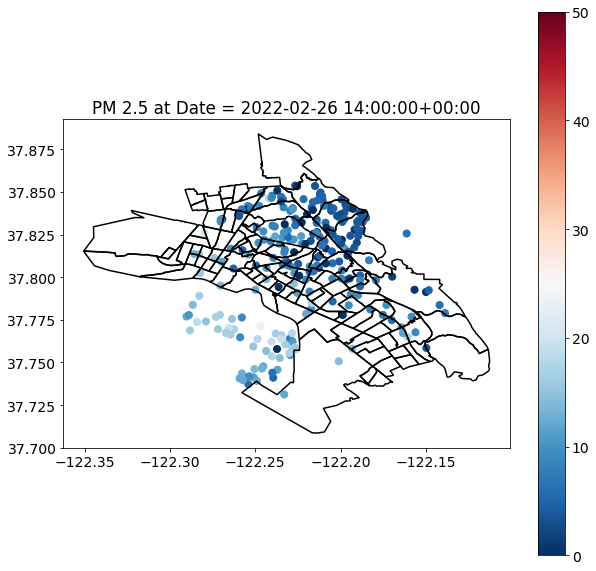

In [ ]:
i_date = 300                                  #date inded
date = dates[i_date]                          #select date
df_oak_date = df_oak_grouped.get_group(date)  #select group of lat/lon for particular date

fig, ax = plt.subplots(1,1, figsize=(10, 10)) #make figure

#make a scatter plot where 
thing = plt.scatter(
    df_oak_date['lon'],               #x is the longitude column of our data
    df_oak_date['lat'],               #y is the latitude column of our data
    c=df_oak_date['value'],           #set the color of each point to be a function of the air quality at that location
    s=50,                             #size of point
    cmap='RdBu_r',vmin = 0,vmax = 50  #color map and bounds
)
fig.colorbar(thing,ax=ax)
ax.set_aspect(1)                      #make it so that the x and y don't have different scales
oak_scaled['geometry'].boundary.plot(color = 'k',ax=ax) #plot the oakland neighborhood geometry
ax.set_title("PM 2.5 at Date = {:s}".format(date))

#Interpolating a Scatter Plot

Interpolation is an important part of in-situ measurements (ones that take place in the environment being tested). From distributed sensor networks, we get a bunch of information about what is happening at particular locations. If we are interested in what is happening in a region however, we need to make some assumptions and take a very educated guess about what is happening between our measured points. We call this educated guess interpolation. 

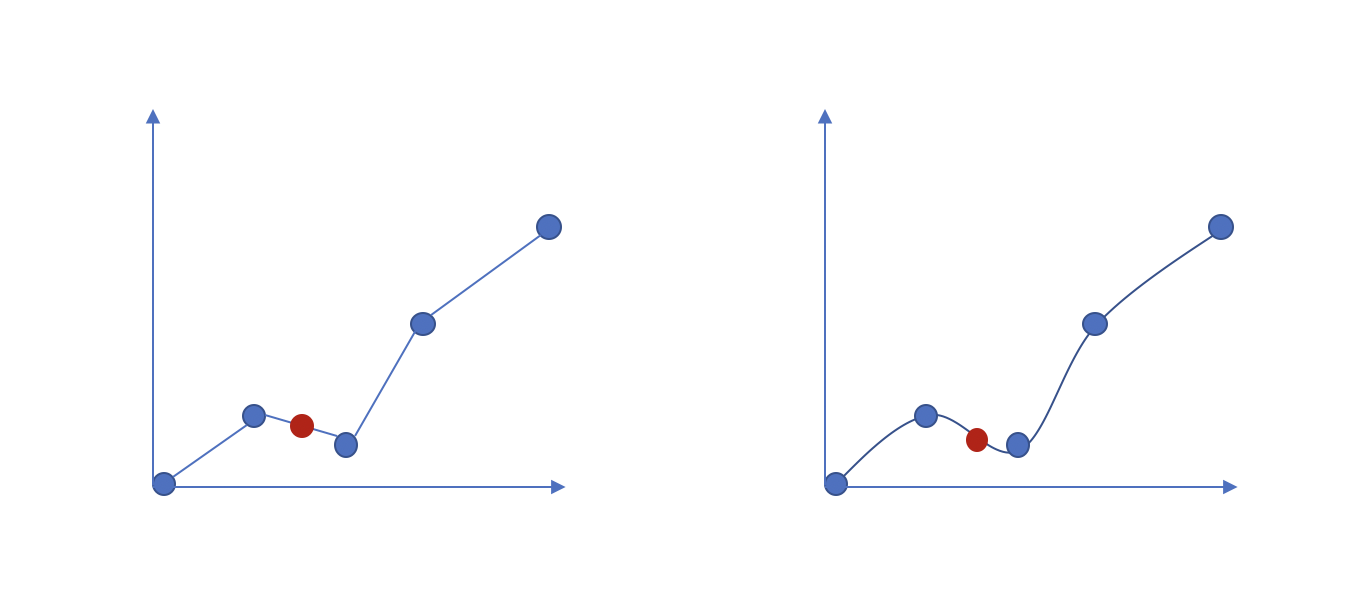

There are many ways of interpolating between known points (in blue), we call these methods. In the diagram above you see a couple of different ways that might be useful for interpolating the values between a set of points. Notice that based on the method that you use to interpolate your data, you can get a different result at a particular point (in red). In the crude "linear" interpolation shown on the right, you see that the red dot is higher or has a larger interpolated value than the smoother "spline" interpolation method shown on the left. In this class, we will not go too much into the gory mathematical details of the different methods you can use, but we will explore the effects that they have on our results in a qualitative way.

While there are many methods of interpolating between points, there are also many broader techniques for how to do this. One such method is called kriging. This is one of the primary methods researcher's who study air quality use.

In [ ]:
def kriging(df,minx,maxx,miny,maxy,vari_mod = "linear"):
  '''
  df: Data frame input should have four columns "date",	"value",	"lat",	"lon"
  minx,...maxy: min and max values for final interpolated map
  Optional input: variogram model type. Options are linear, power, gaussian, spherical, exponential and hole-effect
  '''
  # Dropping all nan values for nan handling
  values = df['value']
  inds_active = ~np.isnan(values)
  xold = df['lon'][inds_active]
  yold = df['lat'][inds_active]
  zold = df['value'][inds_active]

  # Create a 100 by 100 grid
  # Horizontal and vertical cell counts should be the same
  cells = 100
  XX_pk_krig = np.linspace(minx, maxx, cells)
  YY_pk_krig = np.linspace(miny, maxy, cells)

  # Generate ordinary kriging object
  OK = OrdinaryKriging(xold,yold,zold,variogram_model = vari_mod,verbose = False,enable_plotting = False,coordinates_type = "euclidean")

  # Evaluate the method on grid
  Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)
  return XX_pk_krig, YY_pk_krig, Z_pk_krig

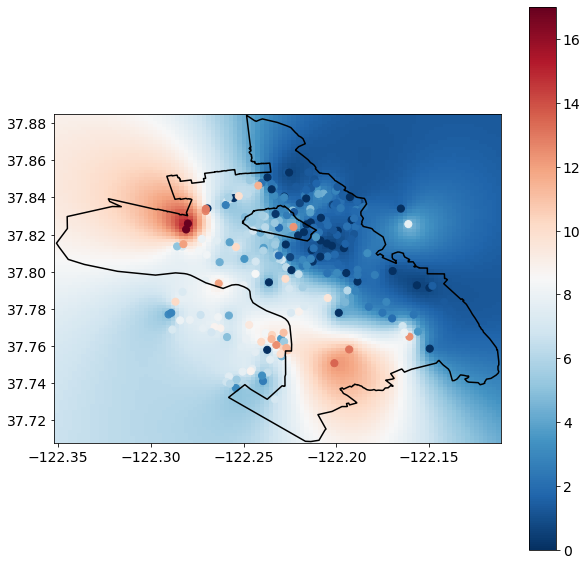

In [ ]:
df_oak_grouped = df_oak.groupby(['date']) #group data to have lat/lon/values divided up by date
dates = df_oak['date'].unique()           #make a list of all dates
df_oak_date = df_oak_grouped.get_group(dates[100])  #select particular date

#Interpolation
#The "kriging" function (defined above) takes in a few arguments. 
# It wants the following:
#     a data frame with lat, lon, and value columns
#     the bounds of the plot you want to generate
XX_pk_krig, YY_pk_krig, Z_pk_krig = kriging(df_oak_date, minx_tot, maxx_tot,miny_tot, maxy_tot) #interpolate

#plot the pm2.5 as a function of space with interpolated values
fig, ax = plt.subplots(1,1, figsize=(10, 10))
all_oak.boundary.plot(color = 'k',ax=ax,cmap='tab20') #plot boundary of oakland
thing = ax.pcolormesh(XX_pk_krig,YY_pk_krig,Z_pk_krig.data,cmap='RdBu_r',vmin=0,vmax = 17)  #plot interpolation results
thingy = plt.scatter(       #plot actual data that the interpolation was based off of
    df_oak_date['lon'], 
    df_oak_date['lat'],
    c=df_oak_date['value'], 
    s=50,
    cmap='RdBu_r',vmin=0,vmax = 17
)
fig.colorbar(thing,ax=ax)
ax.set_aspect(1)

# Problem 2:
**Part A)**
Generate a interpolation for the mean of the data across all of the dates and plot it with the actual mean values for each of the sensors.
Hint: this should look very similar to what was done above but instead of making a df_oak_date, you might want a df_oak_mean

**Part B)**
Compare your time-averaged interpolated results from our low cost pm2.5 sensors to our scientific grade reference BEACO2N sensor network. I have included code below to plot the BEACO2N data from problem 1. Make sure you have not re-defined the variables 'lat', 'lon', 'pm2_5_vals' since we first used them. What conclusions do you draw from this result? Was it what you were expecting? Discuss use cases for the two sensor networks.

Text(0.5, 1.0, 'Date = 2022-02-26 14:00:00+00:00')

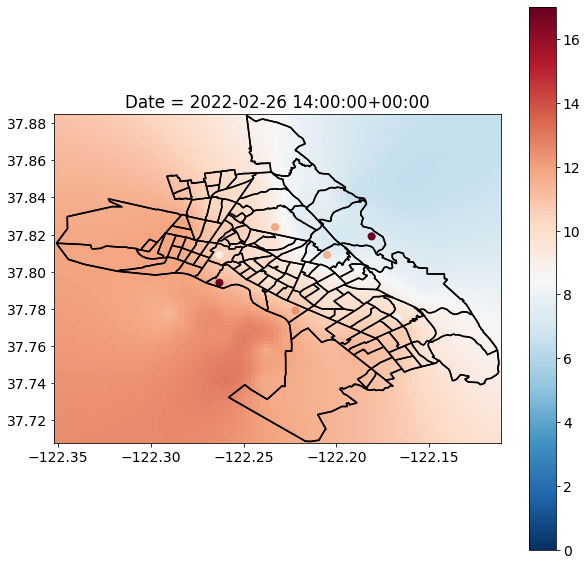

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 10)) #making figure
all_oak.boundary.plot(color = 'k',ax=ax,cmap='tab20') #plotting boundary of oakland
#Note: you may need to change the inputs to the above pcolormesh if you change the variable names of the output of your interpolation
thing = ax.pcolormesh(XX_pk_krig,YY_pk_krig,Z_pk_krig.data,cmap='RdBu_r',vmin=0,vmax = 17)  #plotting interpolated results
thingy = plt.scatter( #making scatter plot of longitude, latitude, and pm2.5 values from beaco2n system
    lon, 
    lat,
    c=pm2_5_vals.mean(axis=0), 
    s=50,
    cmap='RdBu_r',vmin = 0,vmax = 17,
)
#if the scatter plot fails, tripple check you didn't overwrite 'lat','lon', or 'pm2_5_vals'
fig.colorbar(thingy,ax=ax)
ax.set_aspect(1)
oak_scaled['geometry'].boundary.plot(color = 'k',ax=ax)
ax.set_title("Date = {:s}".format(date))

#Air Quality Equity

We have discussed in class to some degree environmental justice -  the idea that those who pollute the most are not suffering the consequenses along with the fact that an disproportate amount of burden of our changing climate is effecting low income and systematically oppressed populations. In this section, we will explore that from a data perspective. In problem 2, we showed the average air quality throughout oakland (albeit for a shor period of time).

We will now use the city of oakland's census and equity data to explore what this overall spatial trend means and who it is effecting.

In [ ]:
import geojson
#pull data
with open('./taking_the_pulse_city_data/GET_2021.geojson', 'r') as f:
  feature_collection = geojson.load(f)

#reformat data
all_features_data = pd.DataFrame()
for feature in feature_collection.features: # 117 features
  feature_geometry = feature.geometry # geojson geometry.
  feature_data = feature.properties # 92 columns!
  feature_id = feature_data['GEOID'] # they provide because it seems like a unique id
  feature_data_df = pd.DataFrame(feature_data, index=[feature_id])
  all_features_data = pd.concat([all_features_data, feature_data_df])


We will let you explore this dataset in problem 3, but as an example for what you can do, we will look at the percentage of the population of each neighborhood that is persons of color.

In [ ]:
metric = all_features_data.PCT_POC # pull neighborhood metric for demographics

#reformat some things. Don't worry about this
pct_poc_dict = {all_features_data.GEOID[i]:metric[i] for i in range(len(all_features_data.GEOID))}
pct_poc_list = []
geoids = oak_scaled.geoid
for x in geoids:
  pct_poc_list.append(pct_poc_dict[x])

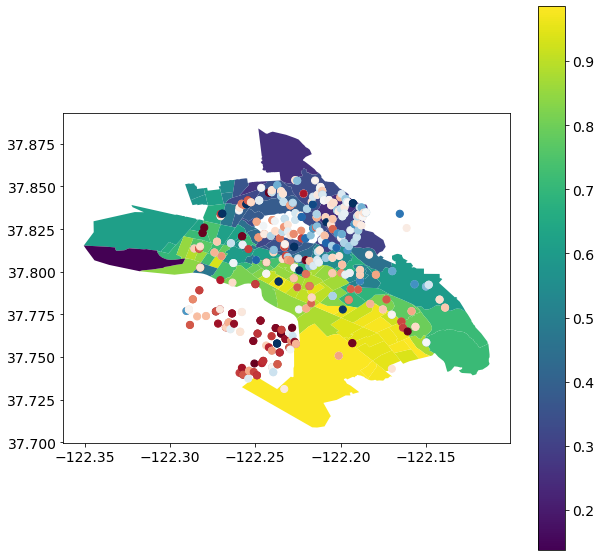

In [ ]:
gdf = gpd.GeoDataFrame({'geometry': oak_scaled.geometry, 'values': pct_poc_list})
fig, ax = plt.subplots(1,1, figsize=(10, 10))

#plot the geometries with the demographic information as a color
gdf.plot(column='values', ax=ax, legend=True)
#plot the mean air quality
thingy = plt.scatter(
    df_oak_mean['lon'], 
    df_oak_mean['lat'],
    c=df_oak_mean['value'], 
    s=50,
    cmap='RdBu_r',vmin=0,vmax = 17)


##Problem 3:
In the plot that we generated above, we see overlayed the percentage of the neighborhood that are persons of color with the mean pm2.5 air quality data available from community based sensors. 

**Part A)** What do you notice about the relationship between air quality and demographics? Do a quick (2-3 minute) google search for what you think might be the main pollutant sources or reasons why more pollutants might gather in these neighborhoods. Explain you findings.

**Part B)** What do you notice about the relationship between the density of sensors and demographics? The majority of this data comes from PurpleAir. What is the economic structure of PurpleAir and how do you get a purple air sensor?

**Part C)** The city of oakland provides demographic data on a neighborhood by neighborhood basis. The demographic information here: https://oakgis.maps.arcgis.com/apps/MapSeries/index.html?appid=fd47784582294d7b87cfb3ee1b047ea8

Look at the different metrics and data available from this dataset. Choose one that you think is interesting. Explain why it is interesting, how they put it together and make a plot overlaying that metric with the air quality data. 